In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import matplotlib.patches as mpatches
import itertools
plt.rcParams['figure.figsize'] = (12.0, 6.0)

In [2]:
# parameters
settings = ['LAN', 'WAN']
#settings = ['LAN']
parties = [0,1]
protocols = ['scs', 'poly']

all_params = itertools.product(settings, parties, protocols)

data_filenames=['p0_lan.out', 'p0_wan.out', 'p1_lan.out', 'p1_wan.out']
#data_filenames=['p0_lan.out', 'p1_lan.out']
raw_data = {}
pir_type = ""
k_A, k_B, l, n, time_reduction, time_total = 0., 0., 0., 0., 0., 0.
for i_setting, setting in enumerate(settings):
    for p in parties:
        with open(data_filenames[p*len(settings) + i_setting]) as f:
            for line in f.read().splitlines():
                fields = line.split()
                if fields[0] == "Running":
                    pir_type = fields[-1][1:-1]
                    if (setting, p, pir_type) not in raw_data:
                        raw_data[(setting, p, pir_type)] = []
                if fields[0] == "l":
                    l = fields[-1]
                if fields[0] == "n":
                    n = fields[-1]
                if fields[0] == "k_A":
                    k_A = fields[-1]
                if fields[0] == "k_B":
                    k_B = fields[-1]
                if fields[0] == "mpc_time:":
                    time_reduction = fields[-2]
                if fields[0] == "Sparse":
                    time_total = fields[-2]
                    if(int(k_A) >= int(k_B)):
                        raw_data[(setting, p, pir_type)] += \
                            [[k_A, k_B, l, n, time_reduction, time_total]]

data = {param : np.array(raw_data[param], dtype=np.float64) for param in raw_data.keys()}

# data is (k_A, k_B, l, n)
f_dense = lambda data,a,b,c: \
    [a * m * data[:,2] * data[:,3] + \
    b * m * data[:,2] + \
    c * m * data[:,3] for m in [data[:,0] + data[:,1]]][0]
fs = {
    'reduction': {
        'scs': lambda data,a,b,c,: [a*m + b*m*np.log2(m) + c 
            for m in [data[:,0] + data[:,1]]][0],
        'poly': lambda data,a,b,c,d: a * data[:,0] * data[:,1] + \
            b * data[:,0] + c * data[:,1] + d,
    },
    'total': { # same for both parties
        'scs': lambda data,a,b,c,d,e,f: fs['reduction']['scs'](data,a,b,c) + \
            f_dense(data,d,e,f),
        'poly': lambda data,a,b,c,d,e,f,g: fs['reduction']['poly'](data,a,b,c,d) + \
            f_dense(data,e,f,g)
    }
}
f_index = {'reduction': 4, 'total': 5}

coeffs = {
    params : {k: curve_fit(fs[k][params[2]], data[params][:,:4], data[params][:,f_index[k]])[0]
              for k in fs.keys()}
    for params in data.keys()
}

def model(params, phase):
    (setting, p, algo) = params
    return lambda data: fs[phase][algo](data, *(coeffs[params][phase]))

/home/adria/.virtualenvs/metisml/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Find parameters for knn in our four datasets

k-NN (LAN)
Languages, ngrams=5 {'reduction': [{'scs': 5.481745261831275, 'poly': 0.64072138807735513}, {'scs': 5.407991238724918, 'poly': 0.5864365415700068}, {'scs': 0.97179490995800655, 'poly': 0.39778353639955122}, {'scs': 127.34213031849104, 'poly': 31.604712731377866}], 'total': [{'scs': 14.040839608525857, 'poly': 10.390819996595383}, {'scs': 13.057586292736232, 'poly': 9.3174782544374466}, {'scs': 1.0823606148187537, 'poly': 0.49620307423174381}, {'scs': 138.73304564133286, 'poly': 46.869942903518677}]}
reduction
total
reduction
total


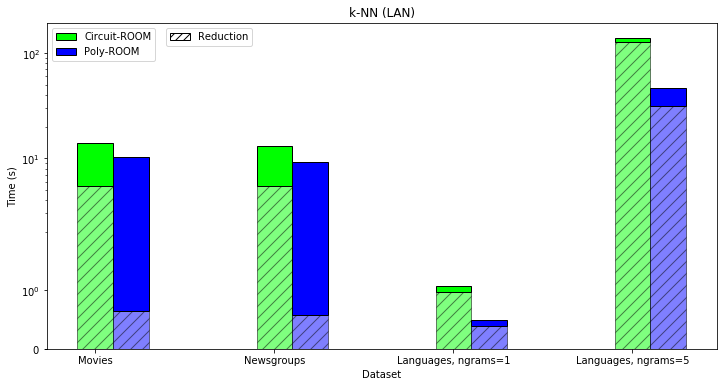


k-NN (WAN)
Languages, ngrams=5 {'reduction': [{'scs': 15.770335857176841, 'poly': 5.2392423061782214}, {'scs': 15.630772213637632, 'poly': 5.1216157050204476}, {'scs': 7.0531649739407518, 'poly': 4.6937830829437912}, {'scs': 237.22383803882639, 'poly': 74.0845878883826}], 'total': [{'scs': 33.355541052878834, 'poly': 18.243690067902207}, {'scs': 31.354138492897619, 'poly': 16.776559250429273}, {'scs': 7.2773042303015245, 'poly': 4.9570482736453414}, {'scs': 260.23089965432882, 'poly': 92.707029551267624}]}
reduction
total
reduction
total


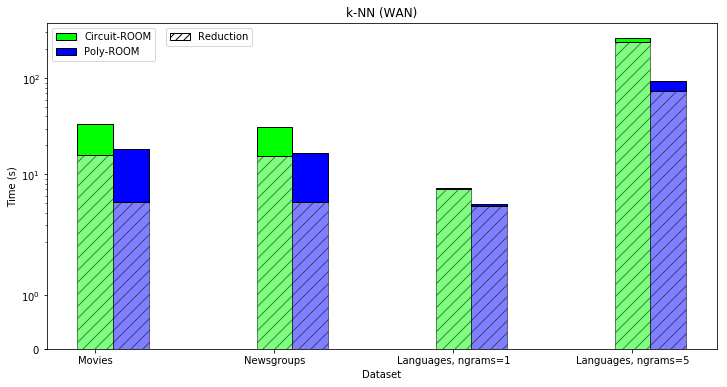

In [3]:
algos = ['scs', 'poly']
labels = ['Circuit-ROOM', 'Poly-ROOM']
phase = 'local + mpc'
party = 0

# Returns running times for knn
def knn(setting, phase, l, m, s_1, s_64, party=0, algos=['scs', 'poly']):
    num_batches = l / 64.
    return {algo: model((setting, party, algo), phase)(np.array([[m * s_64, m * s_1, l, 1]]))[0] for algo in algos}

#(l, m, s_1, s_64)
datasets = {
    'Movies': (10000, 124247, 0.001, 0.028),
    'Newsgroups': (9051, 101631, 0.001, 0.034),
    'Languages, ngrams=1': (783, 1017, 0.023, 0.374),
    'Languages, ngrams=5': (783, 272796, 0.052, 0.1704),
}

bar_width = 0.2
algo_colors = [[0.,1.,0.],[0.,0.,1.]]
phase_brightness = [0.6, 1]
phase_opacity = [0.5, 1]
for setting in ['LAN', 'WAN']:
    print("k-NN ({})".format(setting))
    timings = {k : [] for k in fs.keys()}
    for k in datasets.keys():
        for phase in fs.keys():
            timings[phase] += [knn(setting, phase, *datasets[k])]
    print(k, timings)
    rects = []
    for (i, algo) in enumerate(algos):
        bottom = np.array([0.] * len(datasets))
        for (j, phase) in enumerate(timings.keys()):
            print(phase)
            rect = plt.bar(np.arange(len(datasets)) + i * bar_width, 
                [t[algo] for t in timings[phase]] - bottom, bar_width,
                bottom = bottom,
                color = np.array(algo_colors[i]), # * phase_brightness[j],
                alpha = phase_opacity[j],
                edgecolor = 'black',
                hatch=("//" if phase == 'reduction' else None))
            if j == 1:
                rects += [rect]
            bottom += [t[algo] for t in timings[phase]]
    first_legend = plt.legend(rects, labels)
    ax = plt.gca().add_artist(first_legend)
    plt.legend(handles=[mpatches.Patch(edgecolor='black', facecolor=[1., 1., 1.], hatch='///',label='Reduction')],
                        #mpatches.Patch(edgecolor='black', facecolor=[1., 1., 1.], label='Dense-Mult')],
        loc='upper left', bbox_to_anchor=(0.17, 1))
    plt.xticks(range(len(datasets)), datasets.keys())
    plt.yticks([1,2,3,4])
    plt.xlabel('Dataset')
    plt.ylabel('Time (s)')
    plt.yscale('symlog', linscaley=1, subsy=[2, 3, 4, 5, 6, 7, 8, 9])
    plt.title("k-NN ({})".format(setting))
    plt.savefig('knn_{}.pdf'.format(setting), bbox_inches='tight')
    plt.show()
    print()
    

In [9]:
dataset_sp_acc_map = {}
# for each dataset we store a list of tuples (n, l, m, s_1, s_l), where
# n is num of records, l is batch size, m is num features, s_1 is sparsity of 1 doc, s_l is sparsity of l docs.
dataset_sp_acc_map['Newsgroups'] = [(9051, 1, 101631, 0.00097006705833903621, 0.00097006705833903621), (9051, 2, 101631, 0.00097006705833903621, 0.0018348536475064081), (9051, 4, 101631, 0.00097006705833903621, 0.0034043773464171598), (9051, 8, 101631, 0.00097006705833903621, 0.0061976084300252978), (9051, 16, 101631, 0.00097006705833903621, 0.011094639352514471), (9051, 32, 101631, 0.00097006705833903621, 0.019508343736355082), (9051, 64, 101631, 0.00097006705833903621, 0.033509000122889293), (9051, 128, 101631, 0.00097006705833903621, 0.056017919166958342), (9051, 256, 101631, 0.00097006705833903621, 0.091614341518406223), (9051, 512, 101631, 0.00097006705833903621, 0.14604564262756789), (9051, 1005, 101631, 0.00097006705833903621, 0.22847687549402576), (9051, 1024, 101631, 0.00097006705833903621, 0.22728301404099144), (9051, 1131, 101631, 0.00097006705833903621, 0.24493756826165244), (9051, 1293, 101631, 0.00097006705833903621, 0.26727362433003427), (9051, 1508, 101631, 0.00097006705833903621, 0.29456071474254902), (9051, 1810, 101631, 0.00097006705833903621, 0.33141659533016499), (9051, 2048, 101631, 0.00097006705833903621, 0.35178488846906947), (9051, 2262, 101631, 0.00097006705833903621, 0.38105007330440516), (9051, 3017, 101631, 0.00097006705833903621, 0.45990232638991385), (9051, 4096, 101631, 0.00097006705833903621, 0.54293965423935608), (9051, 4525, 101631, 0.00097006705833903621, 0.58849170036701404), (9051, 8192, 101631, 0.00097006705833903621, 0.83696903503852171)]
dataset_sp_acc_map['Languages, ngrams=1'] = [(783, 1, 1033, 0.042133230469846288, 0.042133230469846288), (783, 2, 1033, 0.042133230469846288, 0.062032220607423076), (783, 4, 1033, 0.042133230469846288, 0.089393600913446031), (783, 8, 1033, 0.042133230469846288, 0.12768335645352841), (783, 16, 1033, 0.042133230469846288, 0.19167473378509198), (783, 32, 1033, 0.042133230469846288, 0.27319296547273314), (783, 64, 1033, 0.042133230469846288, 0.38407550822846082), (783, 87, 1033, 0.042133230469846288, 0.4322899860169947), (783, 97, 1033, 0.042133230469846288, 0.45002420135527588), (783, 111, 1033, 0.042133230469846288, 0.48112294288480156), (783, 128, 1033, 0.042133230469846288, 0.50516295579219106), (783, 130, 1033, 0.042133230469846288, 0.51000322684737021), (783, 156, 1033, 0.042133230469846288, 0.54617618586640859), (783, 195, 1033, 0.042133230469846288, 0.5951113262342691), (783, 256, 1033, 0.042133230469846288, 0.64698289770893835), (783, 261, 1033, 0.042133230469846288, 0.65408196192320101), (783, 391, 1033, 0.042133230469846288, 0.74830590513068729), (783, 512, 1033, 0.042133230469846288, 0.7947725072604066)]
dataset_sp_acc_map['languages, ngrams=5'] = [(783, 1, 272836, 0.0052030470468021183, 0.0052030470468021183), (783, 2, 272836, 0.0052030470468021183, 0.0097969723640507801), (783, 4, 272836, 0.0052030470468021183, 0.018138237265478536), (783, 8, 272836, 0.0052030470468021183, 0.032908104003568167), (783, 16, 272836, 0.0052030470468021183, 0.058476444335302767), (783, 32, 272836, 0.0052030470468021183, 0.10124305443563165), (783, 64, 272836, 0.0052030470468021183, 0.17043449789128512), (783, 87, 272836, 0.0052030470468021183, 0.21225327058501567), (783, 97, 272836, 0.0052030470468021183, 0.22897683956662609), (783, 111, 272836, 0.0052030470468021183, 0.25235882152124878), (783, 128, 272836, 0.0052030470468021183, 0.27782990514448241), (783, 130, 272836, 0.0052030470468021183, 0.28089584952132418), (783, 156, 272836, 0.0052030470468021183, 0.31767581990646393), (783, 195, 272836, 0.0052030470468021183, 0.36754039056429505), (783, 256, 272836, 0.0052030470468021183, 0.44107204816568679), (783, 261, 272836, 0.0052030470468021183, 0.44678854696594289), (783, 391, 272836, 0.0052030470468021183, 0.57597787681977453), (783, 512, 272836, 0.0052030470468021183, 0.67661892125672563)]
dataset_sp_acc_map['Movies'] = [(10000, 1, 74849, 0.0018439591711312106, 0.0018439591711312106), (10000, 2, 74849, 0.0018439591711312106, 0.0033403652687410651), (10000, 4, 74849, 0.0018439591711312106, 0.0059082953680075889), (10000, 8, 74849, 0.0018439591711312106, 0.010214250023380405), (10000, 16, 74849, 0.0018439591711312106, 0.017293868989565659), (10000, 32, 74849, 0.0018439591711312106, 0.028653029980703029), (10000, 64, 74849, 0.0018439591711312106, 0.046376448172063343), (10000, 128, 74849, 0.0018439591711312106, 0.073225547092933441), (10000, 256, 74849, 0.0018439591711312106, 0.11254419581852147), (10000, 512, 74849, 0.0018439591711312106, 0.16812234597234713), (10000, 1024, 74849, 0.0018439591711312106, 0.24369656835020434), (10000, 1111, 74849, 0.0018439591711312106, 0.25351782329163458), (10000, 1250, 74849, 0.0018439591711312106, 0.26916191265080364), (10000, 1428, 74849, 0.0018439591711312106, 0.28767633120396685), (10000, 1666, 74849, 0.0018439591711312106, 0.31042498897780868), (10000, 2000, 74849, 0.0018439591711312106, 0.33893839597055408), (10000, 2048, 74849, 0.0018439591711312106, 0.34378214805809026), (10000, 2500, 74849, 0.0018439591711312106, 0.37680864139801468), (10000, 3333, 74849, 0.0018439591711312106, 0.42922417133161433), (10000, 4096, 74849, 0.0018439591711312106, 0.47234431989739339), (10000, 5000, 74849, 0.0018439591711312106, 0.51368087750003344), (10000, 8192, 74849, 0.0018439591711312106, 0.63633448676669024)]

# For each configuration and dataset in dataset_sp_acc_map
# We estimate running time and pick the fastest configuration
fastest_conf = {}
for (dataset, conf_list) in dataset_sp_acc_map.items():
    fastest_conf[dataset] = (None, None, float("inf"))
    for conf in conf_list:
        #print(conf)
        (n, l, m, s_1, s_l) = conf
        (f_alg, f_conf, f_time) = fastest_conf[dataset]
        for (alg, time) in knn('LAN', 'total', l, m, s_1, s_l).items():
            num_blocks = float(n // l)
            if f_time > time * num_blocks:
                fastest_conf[dataset] = (alg, (l, m, s_1, s_l), time * num_blocks)
print(fastest_conf)
        

{'Newsgroups': ('poly', (512, 101631, 0.0009700670583390362, 0.1460456426275679), 57.954987704753876), 'Languages, ngrams=1': ('poly', (512, 1033, 0.04213323046984629, 0.7947725072604066), 0.60094005987048149), 'languages, ngrams=5': ('poly', (512, 272836, 0.005203047046802118, 0.6766189212567256), 38.365582942962646), 'Movies': ('poly', (512, 74849, 0.0018439591711312106, 0.16812234597234713), 58.421187818050385)}
